![](http://)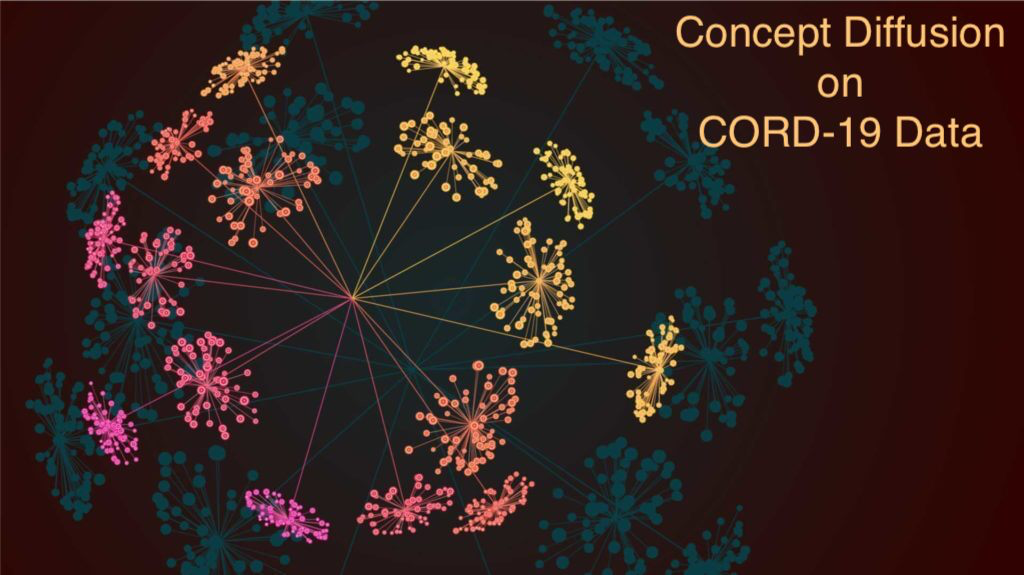

This is a joint project by Avinash Vyas and Dan Kushnir


© 2020 Nokia Licensed under the BSD 3-Clause License SPDX-License-Identifier: BSD-3-Clause

# Goal
To adderess the COVID-19 Open Research Dataset Challenge, we aim to provide a generic search tool that a researcher or a doctor can use to quickly find sections/paragraphs of papers/articles that are most relevant to a concept or question they have related to Covid-19 or other viruses studied in the past thus saving time and effort. In addition to finding the information relevant to the official tasks posed in the challenge, the tool allows one to find information related to orthogonal or subsequent questions e.g. What is the target of a drug x? or Which drugs have similar effect?. It can also be used to find correlation between two seemingly independent concepts. 

# Approach
We intent to match a task description to paragraph that are semantically similar. To achieve that, we encode each task description and paragraphs of documents/articles to an embedding vector space using a deep learning model (Universal Sentence Encoder [[1](https://arxiv.org/abs/1803.11175)]) and find semantic similarity between them. The Universal Sentence Encoder (USE) is an extremely popular model for encoding text, and used in many Natural Language Processing (NLP) tasks. We found that the semantic similarity in embedded space does not always find all the desired matches as in many cases the task description are either not specific or mention several diverse concepts. Hence we improve the obtained results using two fold approach. First we provide a feature that allows a user to select relevant paragraphs from the result of top-k matches to a given task description, we call them *seeds*, and recursively find semantically similar paragraph to these seeds. Second, we use the novel concept of "Diffusion" from active learning, on a k-nearest neighbor graph constructed using the USE embeddings of all the paragraphs of the documents.     

# Description
We have built a pipeline of the following processing modules

1. **ETL** - extract a representation of each article in the CORD-19 data corpus,
2. **Encoding** - compute the Universal Sentence Encoder (USE) encoding of the extracted representation of each article. (This is a computationaly expensive step which takes 2-3 hours. To save time we have precomputed embeddings and uploaded them as input data source. To use them instead of computing them, please skip the step marked as optional below and uncomment the filename pointing to the input data)
3. **Seed Generation** - use the sub-task or a related question to find top-k matching articles from the CORD-19 data corpus
4. **Representation** - use the deep-encoding to create a contextual graph
5. **Diffusion** - using the top-k matches as seed, use the process of diffusion on the graph to find contextually similar document. Reports the sets of intersection, and a visualization.

In [ ]:
pip install pickledb

In [ ]:
import pandas
import json
import csv
import tensorflow_hub as hub
import numpy as np
import pickle
import pickledb
import random
import os

# Encoding
Next we show the code to compute the USE embeddings of all the paragraphs of the documents and the articles in the CORD-19 data set. *This s a computationaly expensive step which takes 2-3 hours. To save time we have precomputed embeddings and uploaded them as input data source.* 

In [ ]:

class EmbeddingStore:
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

    def __init__(self, filename):
        self.embedding_file = filename
        self.all_docs_embeddings = self.read_embeddings()
        if self.all_docs_embeddings is None:
            print("all_docs initialized to None")

    def print_embeddings(self):
        if self.all_docs_embeddings is None:
            print("Not initialized")
        else:
            print(self.all_docs_embeddings.shape)

    def save_embeddings(self):
        f = open(self.embedding_file, 'wb')
        pickle.dump(self.all_docs_embeddings, f)

    def read_embeddings(self):
        try:
            f = open(self.embedding_file, 'rb')
        except FileNotFoundError:
            return None
        try:
            embeddings_ = pickle.load(f)
        except EOFError:
            embeddings_ = None
        return embeddings_

    def mergeInOrder(self, filename):
        f = open(filename, 'rb')
        try:
            new_embeddings_ = pickle.load(f)
        except EOFError:
            new_embeddings_ = None
        combined_embeddings_ = np.concatenate((self.all_docs_embeddings, new_embeddings_))
        self.all_docs_embeddings = combined_embeddings_
        print("Merged embeddings = {}".format(len(self.all_docs_embeddings)))
        self.save_embeddings()

    def add_embeddings(self, new_embeddings_):
        if self.all_docs_embeddings is None:
            combined_embeddings_ = new_embeddings_
        else:
            combined_embeddings_ = np.concatenate((self.all_docs_embeddings, new_embeddings_))
        self.all_docs_embeddings = combined_embeddings_

    def dump(self):
        self.save_embeddings()

    def add_paras(self, new_paras_):
        new_embeddings_ = self.embed(new_paras_)
        self.add_embeddings(new_embeddings_)

    def add_para(self, new_para_):
        new_embeddings_ = self.embed([new_para_])
        self.add_embeddings(new_embeddings_)

    def add_para_new(self, new_para_):
        t = tf.cast(t, tf.string)
        t = tf.string_split([t], delimiter).values
        e = self.embed(t)
        e = tf.reduce_mean(e, axis=0)
        self.add_embeddings(tf.squeeze(e))

    def find_top_match(self, query):
        #print("Query received = {}".format(query))
        query_embedding_ = self.embed(query)
        #print(query_embedding_.shape) 
        #print(query_embedding_[0].shape)
        #print(self.all_docs_embeddings.shape)
        corr = np.inner(query_embedding_[0], self.all_docs_embeddings)
        #print(corr)
        value = np.amax(corr)
        pos = np.where(corr == value)
        #print(pos)
        #print("Match = {} at index {}".format(value, pos[0][0]))
        return pos[0][0]

    def find_top_k_match(self, query, k):
        print("Query received = {}".format(query))
        query_embedding_ = self.embed(query)
        print(query_embedding_.shape)
        print(query_embedding_[0].shape)
        print(self.all_docs_embeddings.shape)
        corr = np.inner(query_embedding_[0], self.all_docs_embeddings)
        print(corr)
        values = np.argpartition(corr, -k)[-k:]
        print("Top K matches for = {} at {}".format(query, values))
        return values

    def find_top_k_match_with_conf(self, query, k):
        query_embedding_ = self.embed(query)
        corr = np.inner(query_embedding_[0], self.all_docs_embeddings)
        indexes = np.argpartition(corr, -k)[-k:]
        values = []
        for i in indexes:
            values.append((i,corr[i]))
        #print("Top K matches for = {} at {}".format(query, values))
        return values

class ParaStore:

    def __init__(self, docsfilename, embeddingsfile):
        self.docfile = docsfilename
        self.embeddingstore = EmbeddingStore(embeddingsfile)
        self.all_docs = self.read_para()
        self.nos_docs = self.all_docs.totalkeys()
        print("There are {} docs in the store".format(self.nos_docs))

    # Merge the pickledbs 
    def mergeInOrder(self, filename, embeddingsfile):
        doc2 = pickledb.load(filename, False)
        rangekey = doc2.totalkeys()
        for i in range(rangekey):
            para = doc2.get(str(i))
            self.all_docs.set(str(self.nos_docs), para)
            self.nos_docs +=1
        self.all_docs.dump()
        self.embeddingstore.mergeInOrder(embeddingsfile)

    def save_para(self):
        self.all_docs.dump()

    def read_para(self):
        docs = pickledb.load(self.docfile, False)
        return docs

    # Changed this function to use the aid instead of text
    def already_exists(self, new_para):
        allkeys = self.all_docs.getall()
        for key in allkeys:
            candidate = self.all_docs.get(key)
            if new_para["aid"] == candidate["aid"] and new_para["pid"] == candidate["pid"]:
                print("({},{}) already in the doc store".format(new_para["aid"], new_para["pid"]))
            #if new_para["aid"] == self.all_docs.get(key)["aid"]:
            #    print("{} already in the doc store".format(new_para["aid"]))
                return True
        return False

    def add_para(self, new_para):
        text = new_para["text"]
        if not self.already_exists(new_para):
            self.all_docs.set(str(self.nos_docs), new_para)
            #self.embeddingstore.add_para(text)
            self.embeddingstore.add_para_new(text)
            self.nos_docs = self.nos_docs+1
            if self.nos_docs % 1000 == 0:
                self.dump()

    def add_paras(self, paras):
        print("Adding {} paras".format(len(paras)))
        for i in range(len(paras)):
            self.add_para(paras[i])

    def dump(self):
        self.all_docs.dump()
        self.embeddingstore.dump()

    def get_para(self, nos):
        #return self.all_docs.get(str(nos+1))
        return self.all_docs.get(str(nos))

    def get_matching_para(self, query):
        pos = self.embeddingstore.find_top_match(query)
        match = self.get_para(pos)
        return match

    def get_matching_k_para(self, query, k):
        positions = self.embeddingstore.find_top_k_match(query, k)
        matches = {}
        for i in positions:
            match = self.get_para(i)
            matches[str(i)] = match
        return matches

    def get_matching_k_para_with_conf(self, query, k):
        positions = self.embeddingstore.find_top_k_match_with_conf(query, k)
        #print("Input query = {}".format(query))
        matches = []
        for pos in positions:
            i = pos[0]
            match = self.get_para(i)
            matches.append((pos[0], pos[1], match))
        return matches

    def filter_k_randomly(self, matches, k):
        kmatches = {}
        print("Filtering {} from {} matches".format(k, len(matches)))
        if len(matches) <= k:
            return matches
        else:
           indexes = random.sample(matches.keys(), k)
        for i in indexes:
            kmatches[i] = matches[i]
        return kmatches

    def applyFilter(self, filt, text):
        for name in filt:
            if text and name.lower() in text.lower():
                return True
        return False

    def get_including_k_para(self, query, filt, k):
        matches = {}
        allkeys = self.all_docs.getall()
        for key in allkeys:
            candidate = self.all_docs.get(key)
            if (query[0] in candidate["text"]) and (self.applyFilter(filt, candidate["text"])):
                matches[key] = candidate
        kmatches = self.filter_k_randomly(matches, k)
        return kmatches

# Seed Generation
We have extracted the task and subtask descriptions and uploaded them as a data source (task-1-query). The following module take each task description (and subtasks within), compute their USE embeddings and finds top-10 semantically similar paragraphs in the USE embedding space using COSINE similarity. As demonstrated in the example below, this step itself yields interesting and relevant results for many of the subtasks. 

In [ ]:
def openStore(docfile, embedding_file):
    docstore = ParaStore(docfile, embedding_file)
    return docstore

def getTopKMatch(dbfile, embedfile, query, k=1):
    # open the store
    query_vector = [query]
    print("The query vector is {}".format(query_vector))
    docstore = openStore(dbfile, embedfile)
    matches = docstore.get_matching_k_para(query_vector, k)
    return matches

def getTopKMatchWithConf(dbfile, embedfile, query, k=1):
    # open the store
    query_vector = [query]
    #print("The query vector is {}".format(query_vector))
    docstore = openStore(dbfile, embedfile)
    matches = docstore.get_matching_k_para_with_conf(query_vector, k)
    matches.sort(key = lambda x: x[1], reverse=True)
    return matches

def findTitleURL(cord_uid):
    df = pandas.read_csv(metadatafile)
    cand = df.loc[df['cord_uid']== cord_uid]
    title = cand["title"].values[0]
    url = cand["url"].values[0]
    return (title,url)

def findMatches(paragraph, paraFile, embeddingFile):
    print("Paragraph = " + paragraph)
    topk = getTopKMatchWithConf(paraFile, embeddingFile, paragraph, 10)  
    matches = []    
    for cand in topk:
        #print(cand)
        match = {}
        para = cand[2]
        cord_uid = para["aid"]
        title, url = findTitleURL(cord_uid)
        match["title"] = title
        match["url"] = url
        match["text"] = para["text"]
        match["index"] = str(cand[0])
        matches.append(match)
    return matches

def findSeed(taskFile, paraFile, embeddingFile):
    seeddir = "/kaggle/working/seeds/"
    if not os.path.isdir(seeddir):
        os.mkdir(seeddir)
    json_file = open(taskFile, 'r')
    data = json.load(json_file)
    keys = data.keys()
    start = taskFile.find("Task")
    for key in sorted(keys):
        
        outfile = taskFile[start:taskFile.find("_query")] + "_" + key + "_match.csv"
        #print("Outputfile = {}".format(outfile))
        csvwriter = csv.writer(open(seeddir + outfile, 'w'))
        paraText = data[key]["paraText"]
        #print(paraText)
        matches = findMatches(paraText, paraFile, embeddingFile)
        for match in matches:
            csvwriter.writerow([paraText, match["text"], match["index"], match["title"], match["url"]])
            
        
paraFile = "/kaggle/input/cord19parauseembeddings/cord19-para-clean.db"
embeddingFile = "/kaggle/input/cord19parauseembeddings/cord19-para-clean.pkl"
taskFile = "/kaggle/input/task-1-query/Task_1_query.json"
metadatafile = "/kaggle/input/cord19metadata/metadata.csv"

findSeed(taskFile, paraFile, embeddingFile)


# Seed Selection
This is a manual step where an expert selects the paragraphs that best match the task description. To aid this step we have created a webinterface that allows the expert to go through the paragraphs returned by the seed generation step and select the ones that are best match to the task description. The user can find more matches by using the seeds as input to the seed generation phase. Example seed file for Task1 Subtask 2 :

../input/task1seeds/Seedfile_Task_1_Subtask02.csv

644146
641032
916895
671694

The selected seeds are then used as input to our diffusion step as described below.

# Diffusion

In [ ]:
pip install MulticoreTSNE

In [ ]:
import pickle
import pickledb
import pandas
import sys
import time
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
import os

from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy.sparse.linalg import eigs
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import SpectralEmbedding



def read_embeddings(file):
        try:
            f = open(file, 'rb')
        except FileNotFoundError:
            return None
        try:
            embeddings_ = pickle.load(f)
        except EOFError:
            embeddings_ = None
        return embeddings_

def read_para(self):
        docs = pickledb.load(self.docfile, False)
        return docs

def get_para(self, nos):
        return self.docs.get(str(nos))

def make_graph(x, n_neighbors, mode, sparse_mode, sigma, knnfile, nrmd):
    '''
    ***
    
    inputs: 

    x: the data (np.array)
    args: args: the input arguments to the script
    nrmd: if we want the graph matrix to be normalized
    outputs:

    a: the diffusion matrix (scipy.csr_matrix)

    ***
    '''
    n = x.shape[0]
    print(knnfile)
    # construct kneighbors graph from data

    if (id(knnfile) == id('')):
        print('computing knn\n')

        start_time = time.time()
        a = kneighbors_graph(x, n_neighbors, mode='distance')
        print("--- %s seconds ---" % (time.time() - start_time))
        print(a.shape)
        with open('knn'+str(n_neighbors), 'wb') as wfile:
            pickle.dump(a,wfile)
    else:
        with open('knn'+str(n_neighbors), 'rb') as rfile:
            a = pickle.load(rfile)                           
    # simmetrize it 

#print(a[[1,2],:])
    a = a + a.transpose()
#a = np.expm1(-a)
#a = a-a.sign()
#if args.sparse_mode: a = a + sparse.eye(n)

#print(a[[1,2],:])

    if (nrmd):

        # get the un-normalized weight matrix
        norm = (a * sigma).max(axis=1).todense()

        norm = 1. / norm
        a = - a.multiply(norm)
        a = a.expm1()
        a = a - a.sign()
        if sparse_mode: a = a + sparse.eye(n)

        # get the normalized weight matrix
        p = a.sum(axis=1)
        p = 1. / p
        a = a.multiply(p)
        assert a.sum() == n # sanity check
    return a


class diff_vecs:  
    def __init__(self, name, roll):  
        self.name = name  
        self.vec = vec 
   


def diffuse_labels(y=None, train_indices=None, g=None, t=1, class_=1):
    '''
    ***
    
    inputs: 

    y: the labels (np.array)
    train_indices: the indices of the train dataset (list)
    g: the graph (scipy.csr_matrix)
    t: how many diffusion steps (int)

    outputs:

    signal: the soft labels from diffusion (np.array)

    ***
    '''
    n = len(y)

    # get training data labels and normalize in [-1,1]
    y = y[train_indices]
    y = 2 * (y == class_).astype(np.float) - 1
    # get the signal to diffuse
    signal = np.zeros((n))
    signal[train_indices] = y

    # diffuse t times 
    for _ in range(t):
        signal = g.dot(signal)
        signal[train_indices] = y
    return signal

def plot_diff(title,fig_ax, x, signal,training_idx,text,color):
    print('Plotting results')
    fig_ax.scatter(x[:, 0], x[:, 1], s=2**2)
    heatmap = signal[signal>0]
    cmap = 'bwr'


    for ix in training_idx:
        print(ix)
        fig_ax.text(x[ix,0],x[ix,1], str(ix))

    fig_ax.set_title(title, fontsize='x-large')
    fig_ax.scatter(x[signal>0,0], x[signal>0,1],color = 'red')

    fig_ax.scatter(x[training_idx,0], x[training_idx,1], marker='s',  color = color)

    return(fig_ax)


def findPara(pos, docs):
    para = docs.get(str(pos))  # uncomment this line if pos is an integer
    return para['text']


# Function to lookup title for notebook
def findTitle(pos, paraFile=None, metadataFile=None):
    if not paraFile:
        paraFile = "/kaggle/input/embeddings/cord19.db"
    if not metadataFile:
        metadataFile = "/kaggle/input/CORD-19-research-challenge/metadata.csv"
        
    docs = pickledb.load(paraFile, False)
    para = docs.get(str(pos))
    docid = para["aid"]
    metadata = pandas.read_csv(metadataFile)
    cand = metadata[metadata["cord_uid"] == docid]
    title = cand["title"].values[0]
    return docid, title


def main(docs, data, seedFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done):
      
    n = data.shape[0]
    print(n)

    print('starting TSNE')
    print(TSNE_done)
    if (TSNE_done == 0):
#        	print('Doing TSNE_para2')
            X_embedded = TSNE(n_jobs=4).fit_transform(data)
            with open('tsne_para_para2', 'wb') as wfile:
                pickle.dump(X_embedded,wfile)
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
            plt.show()
    else:
            with open(TSNE_file, 'rb') as rfile:
                X_embedded = pickle.load(rfile)


    #creating the graph and intiating diffusion:
    print('Creating graph, and starting diffusion process\n')

    g=make_graph(X_embedded, n_neighbors, mode, sparse_mode, sigma, knnfile, nrmd = 1)
    df = pandas.read_csv(seedFile,header=None)
    meds = ['task x']
    titles = ['tasks xx']
    colors = ['green','yellow','pink','black','brown','grey']
    count = 0

    #fig, ax_array = plt.subplots(1, len(meds), sharex=True, sharey=True)


    print('diffusion loop')
    a = []
    for med in meds:
        seed_idx = df.values.astype(int)
        y = np.ones(n, dtype=int)
        y.astype(int)
        signal = diffuse_labels(y=y, train_indices=seed_idx, g=g, t=titer, class_=1)
        a=np.where(signal>0)
        sd_id_id = np.where((seed_idx) == a[0])


        print('recoeverd results indices: '+str(a))

        color = colors[count]
        count = count+1
    outfilename = seedFile[seedFile.find("Seedfile"):seedFile.find('.')]
    outF = open("/kaggle/working/diffusion/"+ outfilename + "_res" +".txt", "w")
    print('doing '+ str(seedFile))
    # print out the interactions
    for i in a[0]:
        #print('i'+str(i))
        #print(type(i))
        #id, tit = findTitle(i, paraFile='cord19.db', metadataFile='metadata.csv')
        para = findPara(i, docs)
        outF.write('id: '+ str(i) + ' and paragraph: ' + para +  '\n\n')
        #print('id: '+ str(i) + ' and paragraph: ' + para +  '\n')
        #print('id: '+ id + ' and title: ' + tit +  '\n')

    #sys.exit(0)
    print('done')
    
# Data files
paraFile = "/kaggle/input/cord19parauseembeddings/cord19-para-clean.db"
embeddingFile = "/kaggle/input/cord19parauseembeddings/cord19-para-clean.pkl"
metadatafile = "/kaggle/input/CORD-19-research-challenge/metadata.csv"
TSNE_file = "/kaggle/input/tsnepara/tsne_para2"
seedDir = '/kaggle/input/task1seeds'


# Default parameters
sigma = 1
mode = 0
sparse_mode = 0
knnfile = ''
n_neighbors = 4
TSNE_done = 1
titer = 1


def processAllSeeds(dir, paraFile, embeddingFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done):
    outputdir = "/kaggle/working/diffusion/"
    if not os.path.isdir(outputdir):
        os.mkdir(outputdir)
    docs = pickledb.load(paraFile, False) 
    data = read_embeddings(embeddingFile)
    for f in os.listdir(dir):
        if f[0] == '.':
            continue
        seedFile = os.path.join(dir,f)
        print("Invoking main with seedFile = {}".format(seedFile))
        main(docs, data, seedFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done)

processAllSeeds(seedDir, paraFile, embeddingFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done)

# Presentation and Output

In [ ]:
import os
import csv

# If using precomputed results
result_dir = "/kaggle/input/task1result/"
# If using computed results from running the notebook cell for Diffusion
#result_dir = "/kaggle/working/diffusion/"

output_dir = "/kaggle/working/"

def lookupTask1SubTasks(nos):
    if nos == 1:
        subtask = "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery"
    elif nos == 2:
        subtask = "Prevalence of asymptomatic shedding and transmission (e.g., particularly children)"
    elif nos == 3:
        subtask = "Seasonality of transmission"
    elif nos == 4:
        subtask = "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding)"
    elif nos == 5:
        subtask = "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood)"
    elif nos == 6:
        subtask = "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)"
    elif nos == 7:
        subtask = "Natural history of the virus and shedding of it from an infected person"
    elif nos == 8:
        subtask = "Implementation of diagnostics and products to improve clinical processes"
    elif nos == 9:
        subtask = "Disease models, including animal models for infection, disease and transmission"
    elif nos == 10:
        subtask = "Tools and studies to monitor phenotypic change and potential adaptation of the virus"
    elif nos == 11:
        subtask = "Immune response and immunity"
    elif nos == 12:
        subtask = "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings"
    elif nos == 13:
        subtask = "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings"
    elif nos == 14:
        subtask = "Role of the environment in transmission"
    else:
        subtask = "Illegal subtask nos"
    
    return subtask

def extractSubtask(infile):
    index1 = infile.find("Subtask")
    start = index1 + len("Subtask")
    end = start+2
    return infile[start:end]

def extractResultPara(line):
    index1 = line.find("paragraph:")
    start = index1 + len("paragraph:")
    return line[start:].strip()

def text2CSV(infile, outfile):
    csvwriter = csv.writer(open(outfile, 'w'))
    in_file = open(infile, 'r')
    subtasknos = extractSubtask(infile)
    subtask_str = lookupTask1SubTasks(int(subtasknos)) 
    csvwriter.writerow(["Subtask ID", "SubTask Description", "Matching Paragraph"])
    for line in in_file:
        if len(line.strip()) <=0:
            continue
        match = extractResultPara(line)
        csvwriter.writerow([subtasknos, subtask_str, match])
        
    
def convertDiffResultToCSV(dir, outdir):
    for f in os.listdir(dir):
        if f[0] == '.':
            continue
        infile = os.path.join(dir,f)
        f = f[f.find('_')+1:]
        filename = f.split('.')[0] + ".csv"
        outfile = os.path.join(outdir, filename)
        print("Input file {} to Output file {}".format(infile, outfile))
        text2CSV(infile, outfile)

convertDiffResultToCSV(result_dir, ".")